# Personal Information
Name: **Aleksander Mirchev**

StudentID: **15785327**

Email: [**alex.mirchev2@student.uva.nl**](alex.mirchev2@student.uva.nl)

Submitted on: **19.03.2025**

# Data Context
The dataset that is going to be used for the purpose of the "Tinkering with Compression for Constructing Abstractions" research consists of the Abstract Reasoning Corpus (ARC) benchmark for Artificial General Intelligence. ARC is a dataset designed to test and develop artificial intelligence systems capable of human-like reasoning and abstraction, published in 2019. It consists of structured grid-based tasks that require models to generalize patterns, infer transformations, and solve problems using minimal prior knowledge. The task is still relevant to this day as even complex AI architectures still struggle with the tasks and the highest achieved public score is around 60%, whereas the task is generally easy for humans (reaching >85% accuracy).

The goal for this research is to explore how compression can be used to extract meaningful relations between objects and the ARC dataset is specifically selected for these experiments due to the variety in complexity of the different tasks and the various different types of transformations that are illustrated in it. It would also put the results of the experiments in the broader context of the ARC compretition (arcprize.org) and potentially contribute meaningful ideas to the development of general intelligence systems.

# Data Description

The ARC-AGI public dataset consists of 400 unique tasks, each of them consisting of (varying number of) input-output pair training sample grids and a test input grid, from which the test output grid must be inferred. Each grid consist of "pixels" of one of 10 colors (as defined below). The goal of this exploratory analysis is to give a brief overview of how many training samples are there per task, how the input-output grid shapes are distributed and are there apparent classes of tasks.

From Analysis 1 the grids are predominantly square, ranging from 2x2 to 30x30 and the grids preserve their shape after the transformation roughly half of the time. From Analysis 2 we gather that tasks have from 2 to 7 training sample pairs, possibly depending on the complexity of the task (more samples -> less ambiguity). From Analysis 3 we discover that usually tasks do not change too much from input to output (assuming the grid size hasn't changed, these cases are ignored) with the majority of the grids changing less than 20% in a transformation.

Analysis 4 and 5 are more concerned about the construction of the training samples and how objects are defined in the grids. The intuition was that tasks such as object movement, scaling, etc. are the most common and more often infering the task would consist of specific object creation/transformation/removal. To determine what an object is the following definition is used: "neighbouring pixels of the same colors represent a single object". However, logically objects are naturally in some composition and therefore background should not be classified as an object. Most commonly the black color (0) is used for backgrounds in ARC-AGI tasks, however it turned out that 33 of the tasks did not have the color 0 in their grids. That was due to 2 reasons: the grid did not display objects, but rather patterns; or another color (colors) act as background. In similar fashion, the distribution of object counts per task visualises the outliers very clearly. 75% of the tasks have around 20 or less objects in a training pair on average, but outliers have up to 650 objects, signaling that the task would be pattern-related rather than centered around object definition. Of course smaller grids tend to have less objects, therefore this does not define pattern tasks entirely.

In [1]:
# Imports
import os
import json
import glob
import re
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from collections import deque, Counter
import seaborn as sns

### Data Loading

In [2]:
folder_path = "../data/evaluation"
json_files = glob.glob(os.path.join(folder_path, "*.json"))

train_data = {}
test_data = {}

for file in json_files:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        puzzle_id = re.search(r"([\da-f]+)\.json$", file).group(1)

        train_data[puzzle_id] = data["train"]
        test_data[puzzle_id] = data["test"][0]

### Helper functions

Here are some helper functions:
- plot_task - displays task training samples and test input
- filter_train_data - filters training data based on some predicate

In [3]:
cmap = colors.ListedColormap([
    "#000000",   # Black
    "#0074D9",   # Blue
    "#FF4136",   # Red
    "#2ECC40",   # Green
    "#FFDC00",   # Yellow
    "#AAAAAA",   # Grey
    "#F012BE",   # Fuchsia
    "#FF851B",   # Orange
    "#7FDBFF",   # Teal
    "#870C25"    # Brown
])

grid_color = "#555555"

norm = colors.Normalize(vmin=0, vmax=9)

def plot_task(id, task, test, title=""):
    rows = len(task)
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(10,7))

    title = title if title else f"Task {id}"
    fig.suptitle(title, fontsize=16, y=1.05)

    axes = axes.flatten()
    for i, pair in enumerate(task):
        mat_inp = np.array(pair['input'])
        mat_out = np.array(pair['output'])

        norm = colors.Normalize(vmin=0, vmax=9)

        ax_inp = axes[i * cols]
        ax_inp.imshow(mat_inp, cmap=cmap, norm=norm)
        ax_inp.set_title(f"Training Input Grid {i+1}")
        ax_inp.axis('off')

        rows_inp, cols_inp = mat_inp.shape
        for row in range(0, rows_inp +1):
            ax_inp.plot([0-0.5, cols_inp-0.5], [row-0.5, row-0.5], color=grid_color, lw=1)
        for col in range(0, cols_inp +1):
            ax_inp.plot([col-0.5, col-0.5], [0-0.5, rows_inp-0.5], color=grid_color, lw=1)

        ax_out = axes[i * cols + 1]
        ax_out.imshow(mat_out, cmap=cmap, norm=norm)
        ax_out.set_title(f"Training Output Grid {i+1}")
        ax_out.axis('off')
        
        rows_out, cols_out = mat_out.shape
        for row in range(0, rows_out + 1):
            ax_out.plot([0-0.5, cols_out-0.5], [row-0.5, row-0.5], color=grid_color, lw=1)
        for col in range(0, cols_out + 1):
            ax_out.plot([col-0.5, col-0.5], [0-0.5, rows_out-0.5], color=grid_color, lw=1)

    mat_inp = np.array(test['input'])
    ax_inp = axes[cols - 1]
    ax_inp.imshow(mat_inp, cmap=cmap, norm=norm)
    ax_inp.set_title("Test Input Grid")
    ax_inp.axis('off')

    rows_inp, cols_inp = mat_inp.shape
    for row in range(0, rows_inp +1):
        ax_inp.plot([0-0.5, cols_inp-0.5], [row-0.5, row-0.5], color=grid_color, lw=1)
    for col in range(0, cols_inp +1):
        ax_inp.plot([col-0.5, col-0.5], [0-0.5, rows_inp-0.5], color=grid_color, lw=1)

    for i in range(1, rows):
        axes[i*cols + cols-1].axis('off')

    plt.tight_layout()
    plt.show()

def filter_train_data(train_data, predicate):
    filtered_tasks = {
        key: task
        for key, task in train_data.items()
        if predicate(task) 
    }
    return filtered_tasks

### Analysis 1: 
Analysing grid sizes and how common are grid dimension changes between input and output. This isn't done by task, but rather by training input-output pairs, as different grids may be observed in the same task. This is done using 2 separate heatmaps to display the frequency of matrix shapes (MxN , x=M, y=N)

The takeaways from this graphic is that majority of grids are square, from 2x2 to 30x30 and there is big similarity between input and output dimensions most of the times. Most common shapes are (3,3), (10,10), (15, 15) and (30, 30).

Here also a complimentary bar plot is included to describe the types of changes that can be observed through the training pairs. The majority of training pairs do not observe changes in the size of the grid, and size decrease is twice more frequent than size increase. No grid rotations (X becomes Y, Y becomes X) are observed.

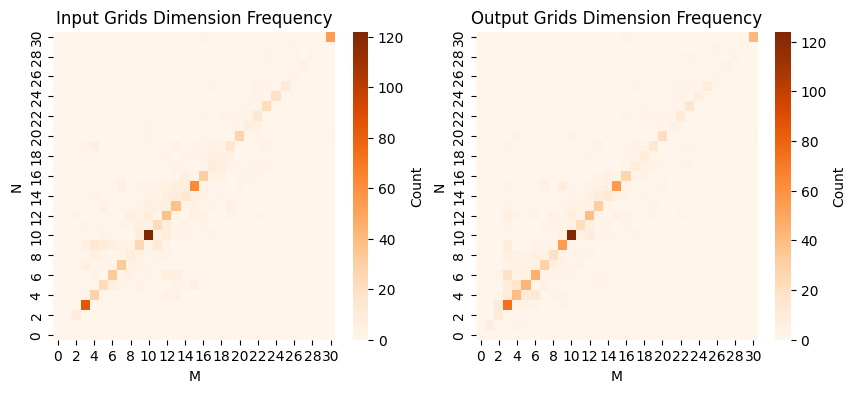

In [ ]:
input_shapes = [np.array(item['input']).shape for value in train_data.values() for item in value]
output_shapes = [np.array(item['output']).shape for value in train_data.values() for item in value]

input_shape_counts = Counter(tuple(shape) for shape in input_shapes)
output_shape_counts = Counter(tuple(shape) for shape in output_shapes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

max_input_rows = max([shape[0] for shape in input_shapes]) if len(input_shapes) > 0 else 0
max_input_cols = max([shape[1] for shape in input_shapes]) if len(input_shapes) > 0 else 0

input_heatmap = np.zeros((max_input_rows + 1, max_input_cols + 1))
for shape, count in input_shape_counts.items():
    input_heatmap[shape[1], shape[0]] = count

sns.heatmap(input_heatmap, ax=ax1, cmap="Oranges", 
            annot=False, cbar_kws={'label': 'Count'})
ax1.set_title('Input Grids Dimension Frequency')
ax1.set_xlabel('M')
ax1.set_ylabel('N')
ax1.invert_yaxis()

max_output_rows = max([shape[0] for shape in output_shapes]) if len(output_shapes) > 0 else 0
max_output_cols = max([shape[1] for shape in output_shapes]) if len(output_shapes) > 0 else 0

output_heatmap = np.zeros((max_output_rows + 1, max_output_cols + 1))
for shape, count in output_shape_counts.items():
    output_heatmap[shape[1], shape[0]] = count

sns.heatmap(output_heatmap, ax=ax2, cmap="Oranges", 
            annot=False, cbar_kws={'label': 'Count'})
ax2.set_title('Output Grids Dimension Frequency')
ax2.set_xlabel('M')
ax2.set_ylabel('N')
ax2.invert_yaxis()

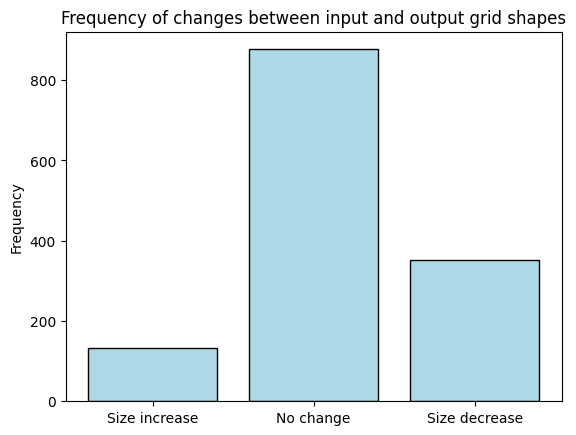

In [5]:
training_samples_shapes = [(np.array(item['input']).shape, np.array(item['output']).shape) for value in train_data.values() for item in value]

def classify_change(shape1, shape2):
    if shape1 == shape2:
        return "No change"
    else:
        size1 = shape1[0] * shape1[1]
        size2 = shape2[0] * shape2[1]
        if size1 > size2:
            return "Size decrease"
        elif size1 < size2:
            return "Size increase"
        else:
            return "Rotated"

diff_in_shapes = [classify_change(item[0], item[1]) for item in training_samples_shapes]

classification_counts = Counter(diff_in_shapes)

labels = list(classification_counts.keys())
counts = list(classification_counts.values())

plt.bar(labels, counts, color='lightblue', edgecolor="black")
plt.ylabel('Frequency')
plt.title('Frequency of changes between input and output grid shapes')
plt.show()

### Analysis 2: 
Complimentary we also need to analyse how many sample input/output pairs are available by task, which is implemented into a bar plot.

The values range from 2 up to 7 training pairs (assuming the tasks are required more training pairs if they are harder and the training pairs are not redundant) with the most common count being 3 in roughly half the tasks (total 400).

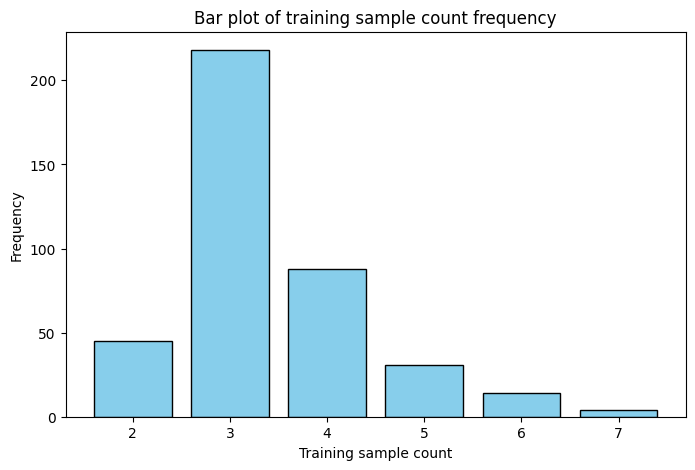

In [6]:
training_samples_count = [len(value) for value in train_data.values()]

sample_counts = {}
for length in training_samples_count:
    if length in sample_counts:
        sample_counts[length] += 1
    else:
        sample_counts[length] = 1

plt.figure(figsize=(8, 5))
plt.bar(sample_counts.keys(), sample_counts.values(), color="skyblue", edgecolor="black")

plt.xlabel("Training sample count")
plt.ylabel("Frequency")
plt.title("Bar plot of training sample count frequency")

plt.show()

### Analysis 3: 

To get better insights of how changes happen, we can explore the count of pixel changes per input/output pair and the percentage of changed pixels, which will be observed only on the samples where the grid size doesn't change (for more clear results). This can be represented with the following histograms.

The main takeaways from these 2 graphics is that most of the training sample pairs contain less than 50 pixels of change and are generally under 20% of the grid size. There are 4 tasks with ids **['fc754716', '6ea4a07e', '50a16a69', '17cae0c1']**, which showcase color coding and pattern inversion.

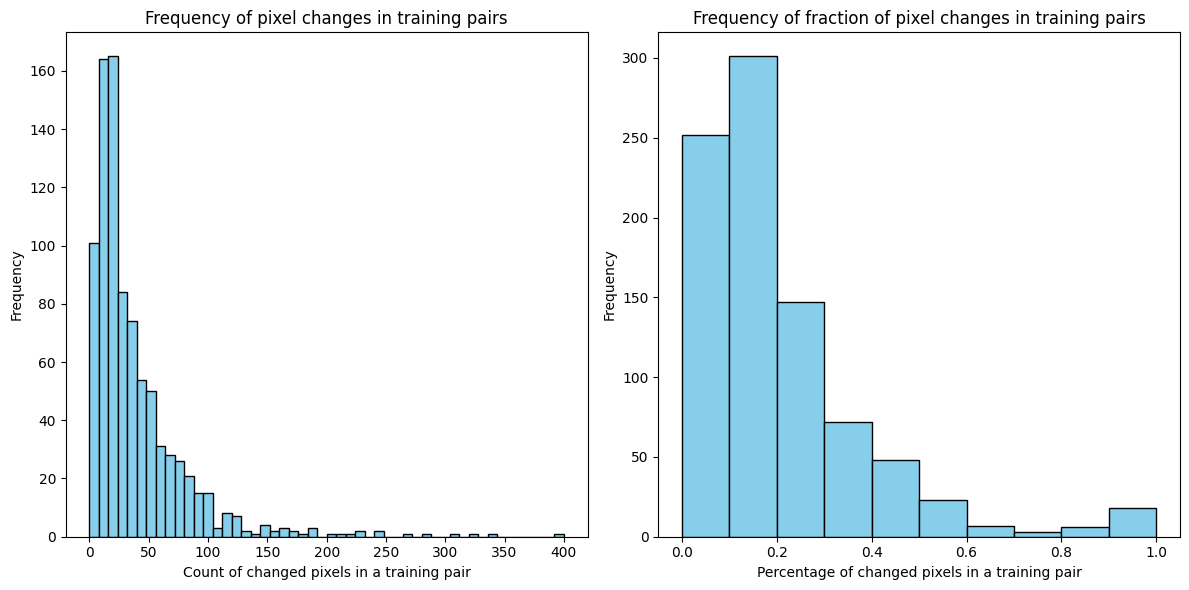

In [ ]:
def extract_pixel_changes(input_grid, output_grid):
    input_array = np.array(input_grid)
    output_array = np.array(output_grid)
    
    if input_array.shape != output_array.shape:
        return None # ignoring those cases
    
    diff = np.sum((input_array != output_array).astype(int))
    return diff

def extract_pixel_changes_task(task):
    pixel_changes = [extract_pixel_changes(item['input'], item['output']) for item in task]
    return [change for change in pixel_changes if change is not None]

def extract_pixel_changes_adjusted(input_grid, output_grid):
    input_array = np.array(input_grid)
    output_array = np.array(output_grid)
    
    if input_array.shape != output_array.shape:
        return None # ignoring those cases
    
    diff = np.sum((input_array != output_array).astype(int)) / (input_array.shape[0] * input_array.shape[1])
    return diff

def extract_pixel_changes_adjusted_task(task):
    pixel_changes = [extract_pixel_changes_adjusted(item['input'], item['output']) for item in task]
    return [change for change in pixel_changes if change is not None]

pixel_changes = [item for task in train_data.values() for item in extract_pixel_changes_task(task)]
pixel_changes_adjusted = [item for task in train_data.values() for item in extract_pixel_changes_adjusted_task(task)]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(pixel_changes, bins=50, color="skyblue", edgecolor='black')
ax[0].set_xlabel('Count of changed pixels in a training pair')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Frequency of pixel changes in training pairs')

ax[1].hist(pixel_changes_adjusted, bins=10, color="skyblue", edgecolor='black')
ax[1].set_xlabel('Percentage of changed pixels in a training pair')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Frequency of fraction of pixel changes in training pairs')

plt.tight_layout()
plt.show()

In [8]:
all_change_ids = []

for task_id in train_data.keys():
    task = train_data[task_id]
    # Extract the adjusted pixel changes for the current task
    pixel_changes_adjusted_for_task = extract_pixel_changes_adjusted_task(task)

    if any(change == 1 for change in pixel_changes_adjusted_for_task):
        all_change_ids.append(task_id)

print("100% change tasks", all_change_ids)
# for key in all_change_ids:
#     plot_task(key, train_data[key], test_data[key])


100% change tasks ['fc754716', '6ea4a07e', '50a16a69', '17cae0c1']


### Analysis 4: 

Another thing to explore in this analysis would be to analyse the compositions of ARC-AGI grids. If we assume the grids to contain "objects" (being constructions of neighbouring pixels with the same color), then logically there appears a need for a definition of "background" to the grids (or the "canvas" in which objects are displayed). The provided color mapping suggests that values of 0 (black) are considered background colors. Therefore the first claim to discover would be whether all tasks contain the background color 0 and what does it suggest?

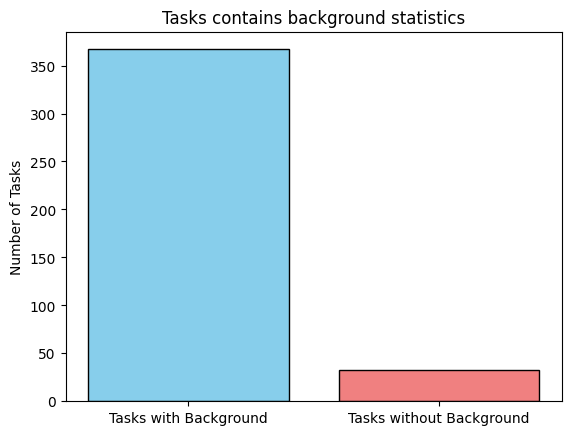

In [6]:
def grid_contains_background_color(grid):
    return np.any(np.array(grid) == 0)

def pair_contains_background(input_grid, output_grid):
    return grid_contains_background_color(input_grid) or grid_contains_background_color(output_grid)

def task_contains_background(task):
    return any([pair_contains_background(item['input'], item['output']) for item in task])

not_bg_tasks = filter_train_data(train_data, lambda task: not task_contains_background(task))
keys = list(not_bg_tasks.keys())

num_bg_tasks = len(filter_train_data(train_data, task_contains_background))
num_not_bg_tasks = len(not_bg_tasks)

labels = ['Tasks with Background', 'Tasks without Background']
values = [num_bg_tasks, num_not_bg_tasks]

plt.bar(labels, values, color=['skyblue', 'lightcoral'], edgecolor='black')
plt.ylabel('Number of Tasks')
plt.title('Tasks contains background statistics')
plt.show()



There are 33 tasks that do not contain background in any of their sample pair grids. They can be classified into 2 different types - **tasks that visualize patterns** and **tasks that visualise object interactions**. 

The pattern class consists of 3 different types of tasks:
- pattern masking completion - complete the task grid's masked sections (dimensions remain the same)
- pattern generation - generate a pattern by applying the input grid (or its symmetric/rotated/etc. grid) multiple times (dimensions increase by factor of input height/width)
- pattern inference - similar to the pattern masking, but only having the inferred mask grid as output (dimensions decrease to size of mask)

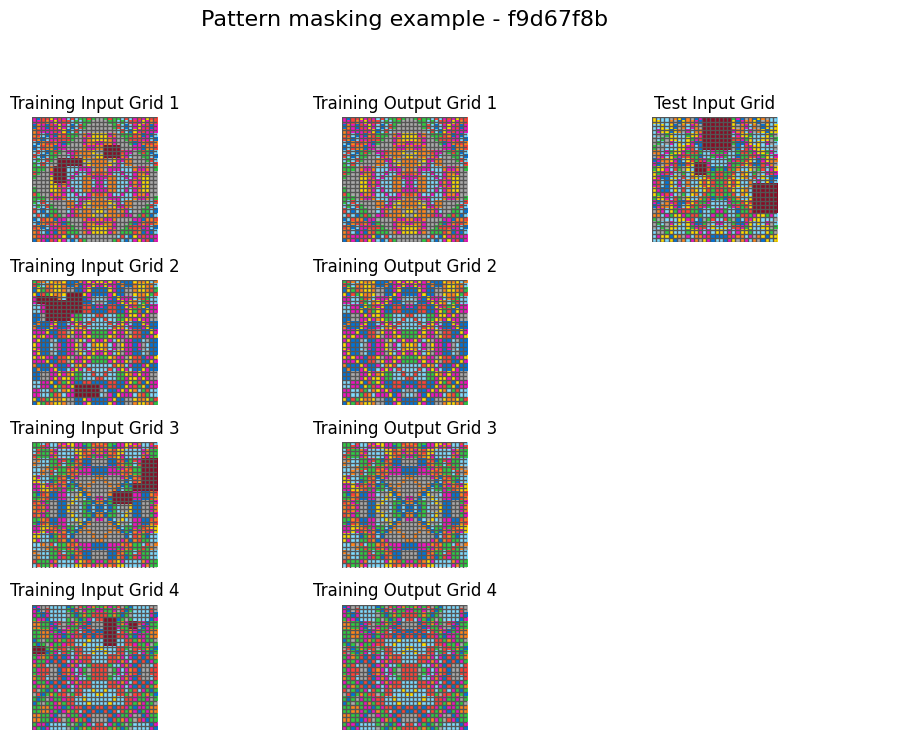

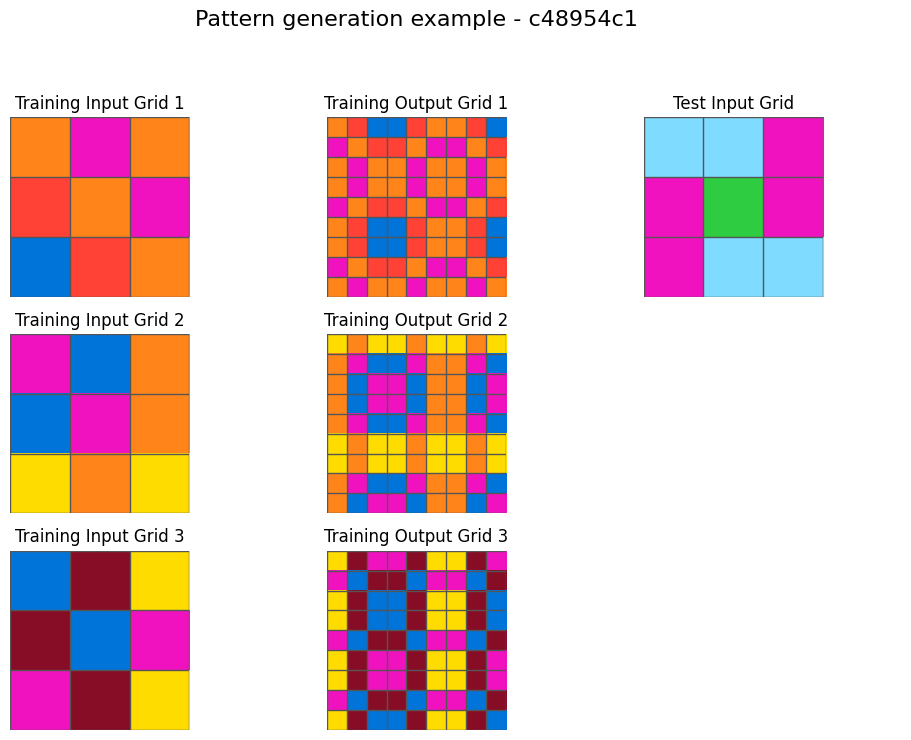

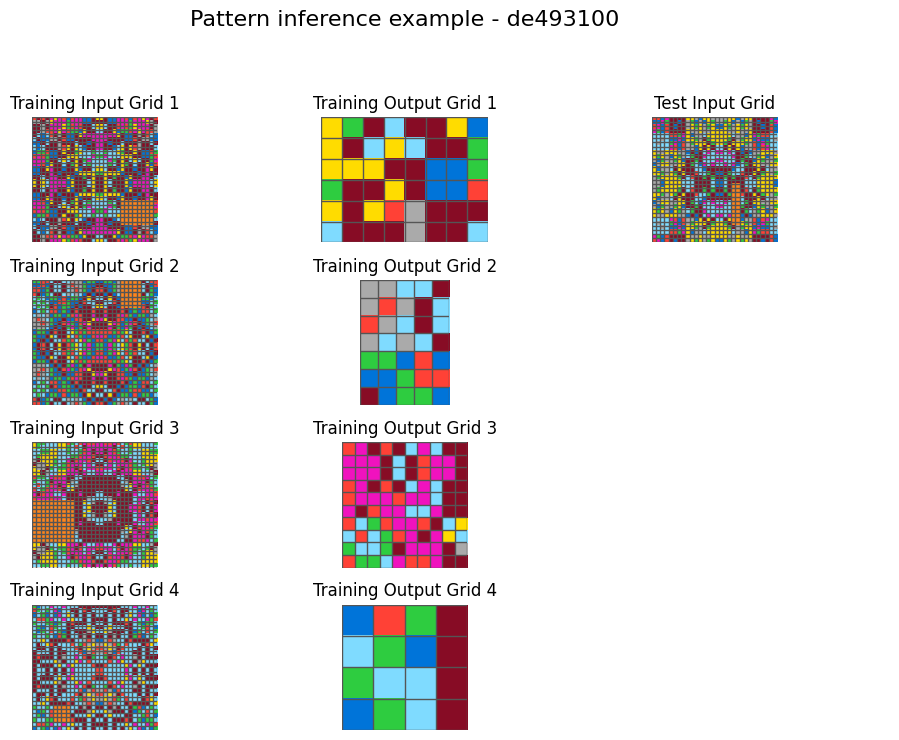

In [ ]:
pattern_masking_ids = [
    'f9d67f8b',    
    '929ab4e9', 
    '47996f11', 
    'f823c43c', 
    '50a16a69',
    'ea959feb',  
    '903d1b4a', 
]
# keys = pattern_masking_ids 
# for key in keys:
#    plot_task(key, train_data[key], test_data[key])

pattern_generation_ids = [
    'c48954c1', 
    '0c786b71', 
    '7953d61e', 
    'bc4146bd', 
    'a59b95c0', 
    '59341089', 
    '3979b1a8', 
    'e633a9e5', 
    '00576224',
    'd4b1c2b1',
]
# keys = pattern_generation_ids
# for key in keys:
#    plot_task(key, train_data[key], test_data[key])

pattern_inference_ids = [
    'de493100', 
    '67b4a34d',
    '0934a4d8', 
    'f4081712', 
]
# keys = pattern_inference_ids
# for key in keys:
#    plot_task(key, train_data[key], test_data[key])


pattern_masking_id = pattern_masking_ids[0]
plot_task(pattern_masking_ids[0], train_data[pattern_masking_ids[0]], test_data[pattern_masking_ids[0]], title=f"Pattern masking example - {pattern_masking_id}")

pattern_generation_id = pattern_generation_ids[0]
plot_task(pattern_generation_ids[0], train_data[pattern_generation_ids[0]], test_data[pattern_generation_ids[0]], title=f"Pattern generation example - {pattern_generation_id}")

pattern_inference_id = pattern_inference_ids[0]
plot_task(pattern_inference_ids[0], train_data[pattern_inference_ids[0]], test_data[pattern_inference_ids[0]], title=f"Pattern inference example - {pattern_inference_id}")

The object class consists of 2 types of tasks:
- tasks where objects are clearly defined, but different background colors are used - substituting the background color is likely to result in a normal task
- tasks where objects exist, however object presence is more abstract

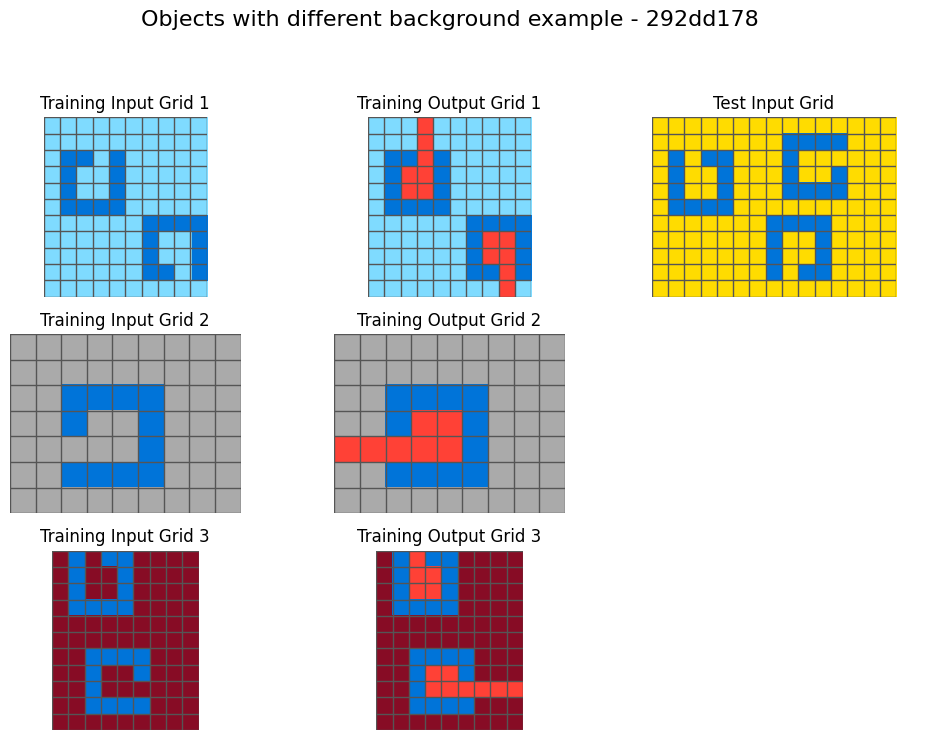

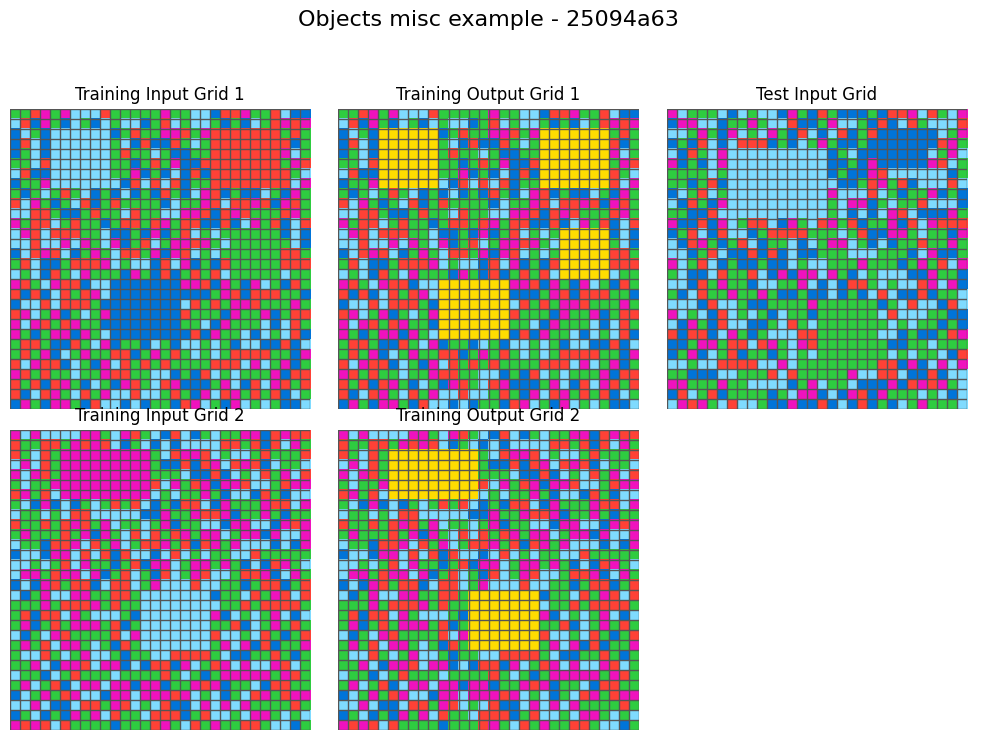

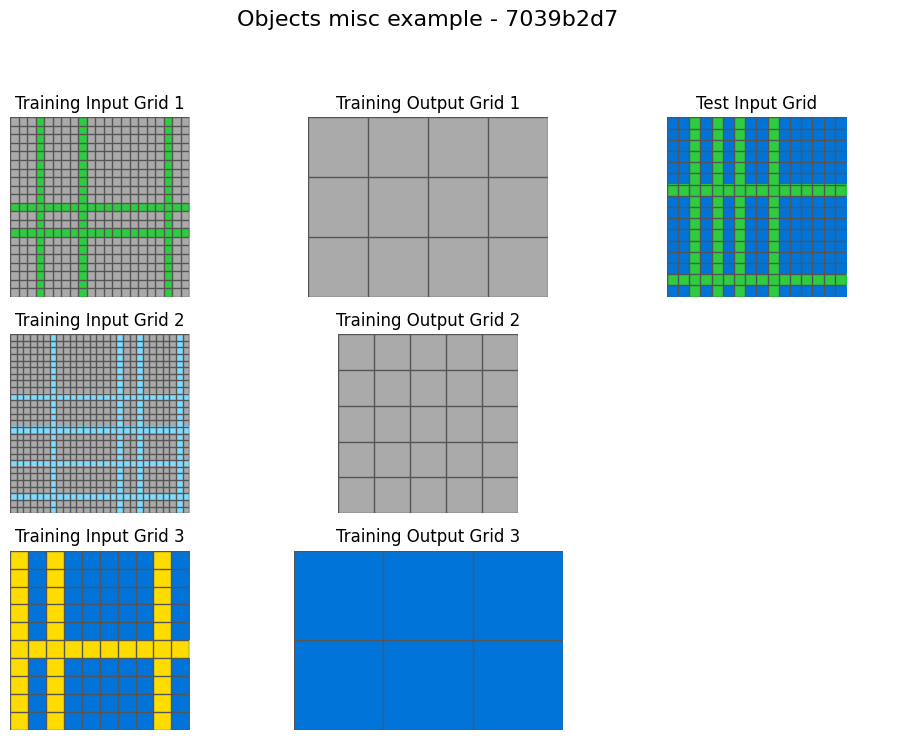

In [ ]:
objects_with_different_background_ids = [
    '292dd178', 
    '55783887', 
    '140c817e', 
    '4364c1c4', 
    'fd096ab6', 
    'aa4ec2a5',
    '9b4c17c4', # dual background
    'aee291af', # extraction of odd object
    'bf699163', # extraction of object that is closed
]
# keys = objects_with_different_background_ids 
# for key in keys:
#    plot_task(key, train_data[key], test_data[key])

objects_misc_ids = [
    '25094a63', # background is random pixels, objects are single color
    '7039b2d7', # counts backgrounds between lines
    'e1baa8a4', # substitutes objects with single pixels
    
]
# keys = objects_misc_ids
# for key in keys:
#    plot_task(key, train_data[key], test_data[key])


objects_with_different_background_id = objects_with_different_background_ids[0]
plot_task(objects_with_different_background_id, train_data[objects_with_different_background_id], test_data[objects_with_different_background_id], title=f"Objects with different background example - {objects_with_different_background_id}")
objects_misc_id = objects_misc_ids[0]
plot_task(objects_misc_id, train_data[objects_misc_id], test_data[objects_misc_id], title=f"Objects misc example 1 - {objects_misc_id}")
objects_misc_id = objects_misc_ids[1]
plot_task(objects_misc_id, train_data[objects_misc_id], test_data[objects_misc_id], title=f"Objects misc example 2 - {objects_misc_id}")

### Analysis 5: 

Following the same definition of object as above (neighbouring pixels of the same color), it is reasonable to analyse object count in terms of ARC-AGI tasks. To evaluate this we plot the mean objects per task training pair ( sum of input and output object count for each training pair of a task, then devided by number of training pairs). The results range from as low as 1 object per task to up to 600 objects per task on average (as per the object definition, which may prove to be too simplistic). However the majority of the tasks (75%) are in the range 1 - 22 objects per sample pair, indicating that higher object counts may be outliers and potentially reveal flows of our object definition.

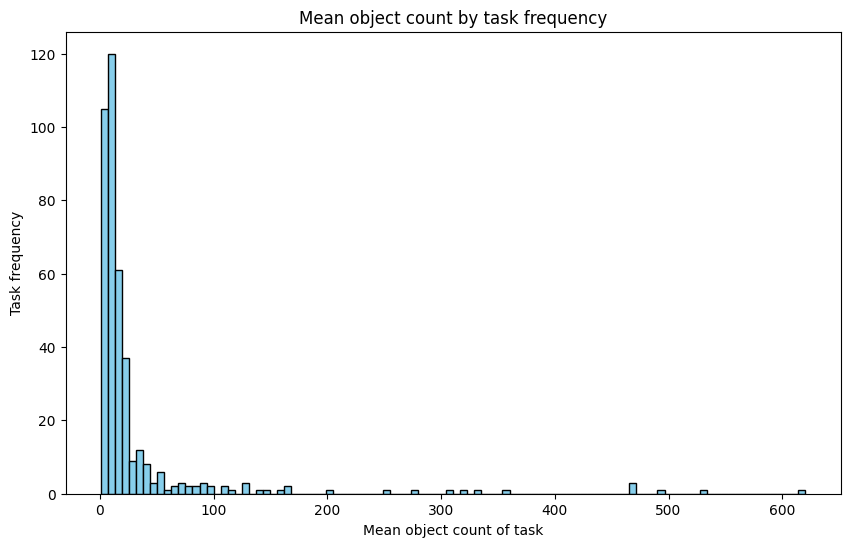

In [ ]:
def get_grid_background(grid):
    if grid_contains_background_color(grid):
        return 0
    
    flat_grid = [cell for row in grid for cell in row]
    counter = Counter(flat_grid)
    
    background_value = counter.most_common(1)[0][0]
    
    return background_value

def count_objects(grid):
    if not grid or not grid[0]:
        return 0  

    m, n = len(grid), len(grid[0])
    background = get_grid_background(grid) 
    visited = [[False] * n for _ in range(m)]
    
    directions = [
        (-1, -1), (-1, 0), (-1, 1),
        (0, -1),        (0, 1),
        (1, -1),  (1, 0), (1, 1)
    ]

    def bfs(x, y, color):
        queue = deque([(x, y)])
        visited[x][y] = True

        while queue:
            cx, cy = queue.popleft()
            for dx, dy in directions:
                nx, ny = cx + dx, cy + dy
                if 0 <= nx < m and 0 <= ny < n and not visited[nx][ny] and grid[nx][ny] == color:
                    visited[nx][ny] = True
                    queue.append((nx, ny))

    object_count = 0

    for i in range(m):
        for j in range(n):
            if grid[i][j] != background and not visited[i][j]: 
                object_count += 1
                bfs(i, j, grid[i][j]) 

    return object_count

def get_task_average_object_count(task):
    return np.mean([count_objects(item['input']) + count_objects(item['output']) for item in task])

task_object_count = [get_task_average_object_count(task) for task in train_data.values()]
plt.figure(figsize=(10, 6))
plt.hist(task_object_count, bins=100, color="skyblue",edgecolor='black')
plt.xlabel('Mean object count of task')
plt.ylabel('Task frequency')
plt.title('Mean object count by task frequency')
plt.show()


To get further insight, we examine the tasks where the average score is above 50. The majority of those tasks are pattern-related as previously defined with most of them being pattern masking and pattern inference (including some other examples where the masking is made using the background color 0). There is also a pattern recognition classification, which are similar to the masking tasks, however do not mask a section of the grid to paint according to symmetry, etc., but have another rule which corresponds to where the input should be changed. 

The rest are mixed and are hard to put in a single category, but range from object interaction (like counting, recolouring) to denoising of a grid, to game-like scenarios (obstacle courses, etc.), but there is a takaway to be made from the variety. The definition of object may need to be enhanced to capture composite objects for a better understanding of how tasks are structured.

['50f325b5', '4ff4c9da', 'f9d67f8b', '891232d6', '67b4a34d', 'e2092e0c', '929ab4e9', '47996f11', 'c92b942c', 'de493100', 'c3202e5a', 'c663677b', '0a1d4ef5', '4f537728', 'a096bf4d', 'ca8f78db', 'e9bb6954', '4aab4007', 'f823c43c', '3194b014', '79369cc6', 'af22c60d', 'aab50785', '25094a63', 'e95e3d8e', '0934a4d8', '15113be4', '1d0a4b61', 'e66aafb8', '1e97544e', '0607ce86', 'bb52a14b', '981571dc', '50a16a69', '212895b5', 'ea959feb', '319f2597', '3ed85e70', 'f4081712', 'f0df5ff0', '1a6449f1', '903d1b4a', '8a371977', 'e681b708', 'b7f8a4d8']


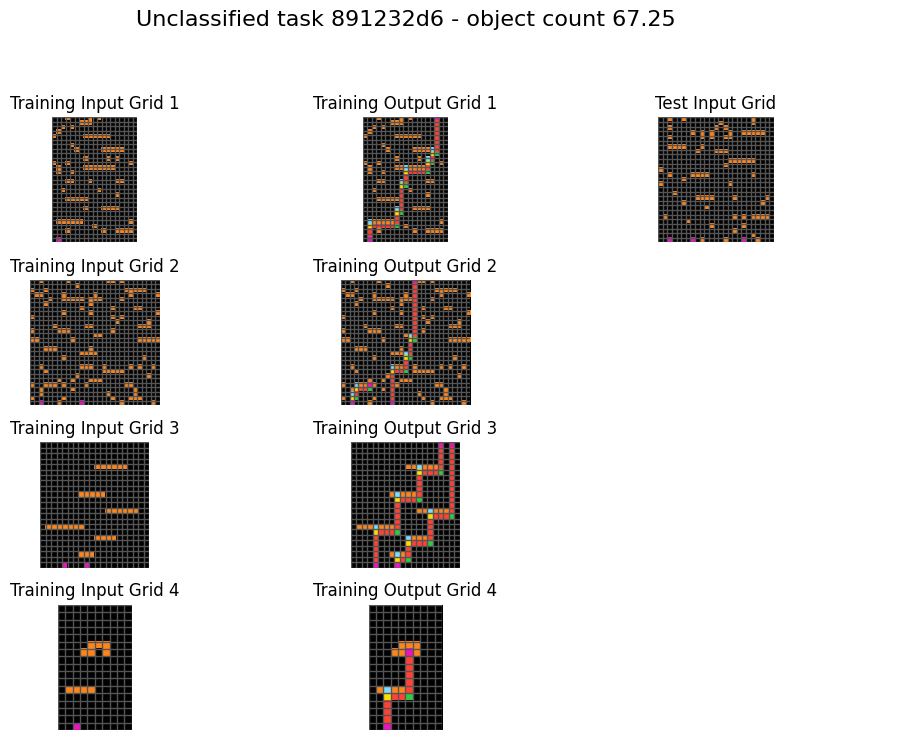

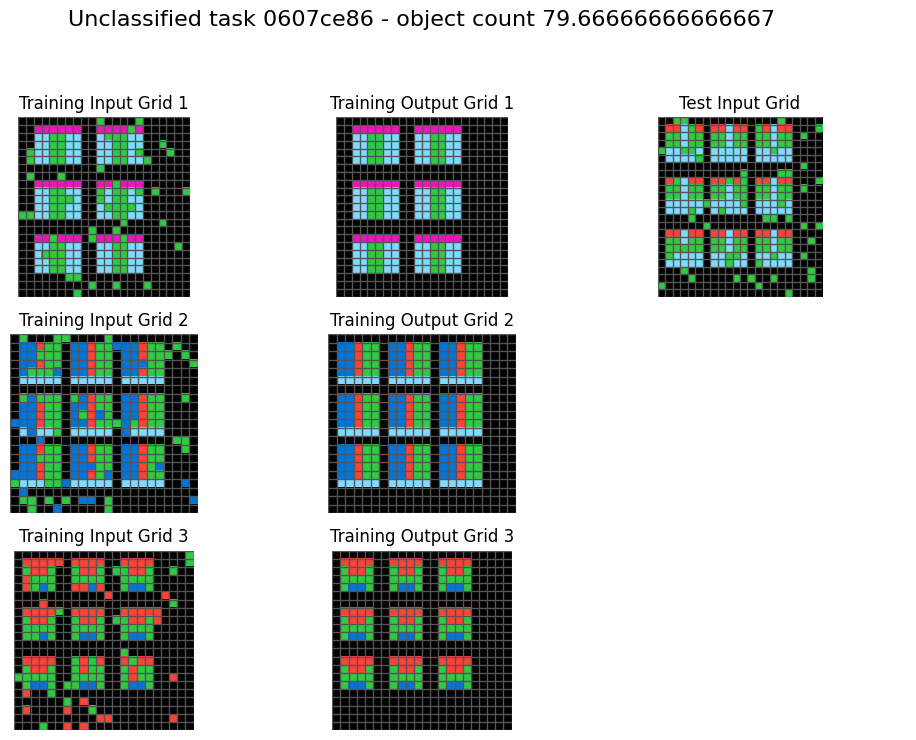

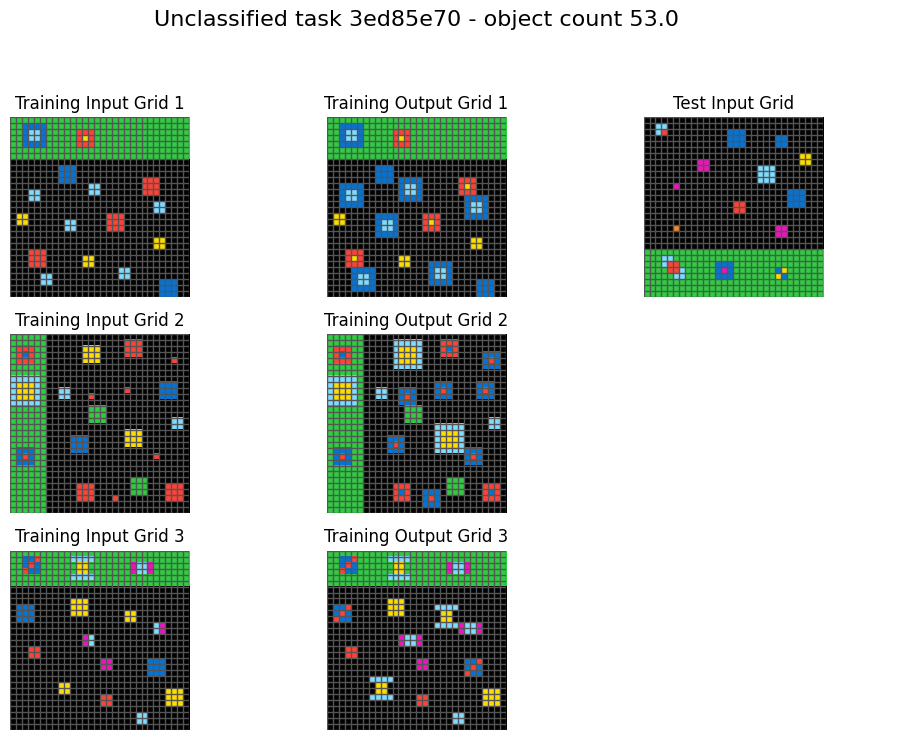

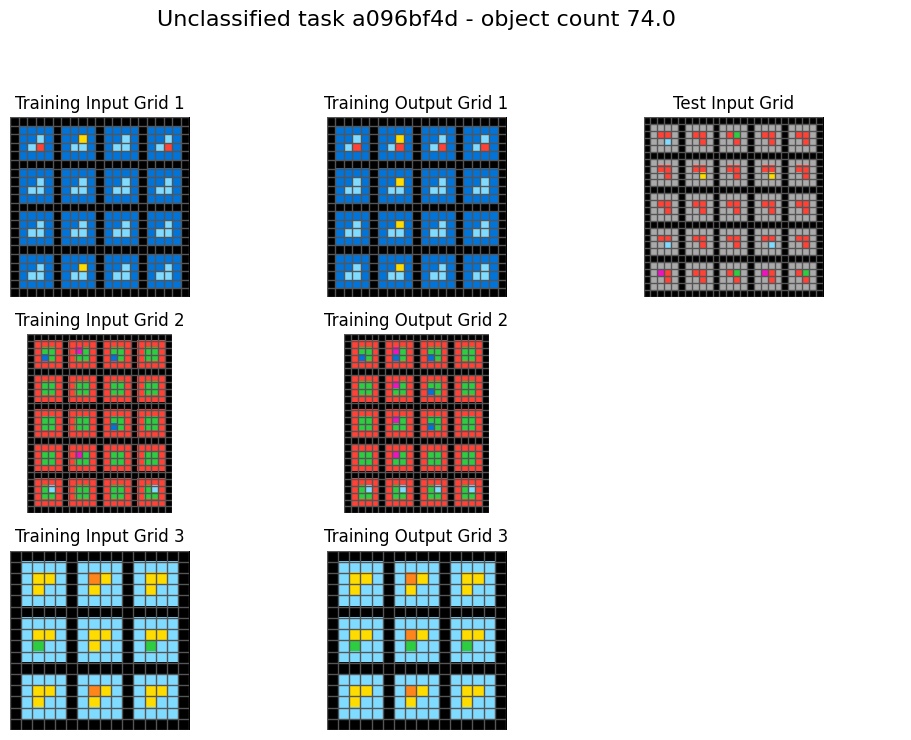

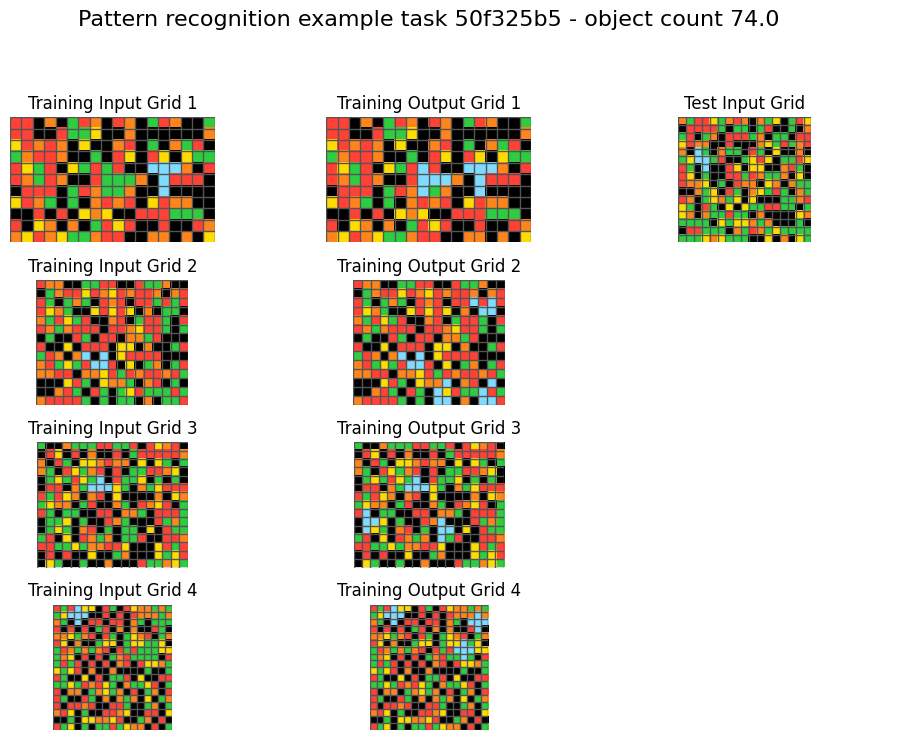

In [54]:
def task_contains_object_count_range(task, r1, r2):
    obj_count = get_task_average_object_count(task)
    
    return obj_count >= r1 and obj_count <= r2

task_range = filter_train_data(train_data, lambda task: task_contains_object_count_range(task, 50, 1000))

keys = list(task_range.keys())
print(keys)

unclassified_ids = [
    '891232d6', # obstacle course
    '0607ce86', # denoising
    '3ed85e70', # composite object
    'a096bf4d', # vertical and horizontal painting of composite objects
    '0a1d4ef5', # detect objects with fuzzy background
    '4f537728', # vertical and horizontal painting of objects
    '3194b014', # counting biggest object color with fuzzy background
    '25094a63', # object detection with fuzzy background
    '212895b5', # obstacles for patterns
    '319f2597', # clearing colors but one in line
    'e681b708', # border game (most coloured squares on the border color the )
    'b7f8a4d8', # composite object core connections
    'e9bb6954', # objects emitting vertical and horizontal lines
]

for key in unclassified_ids[:4]:
   object_count = get_task_average_object_count(train_data[key])
   plot_task(key, train_data[key], test_data[key], title=f"Unclassified task {key} - object count {object_count}")

# what is the difference with masking?
pattern_recognition_ids = [
    '50f325b5', 
    '4ff4c9da', 
    '79369cc6', 
    '15113be4', 
    'bb52a14b', 
    'f0df5ff0',
    'e2092e0c', # circle same pattern
    '8a371977', # painting border objects red, inner green (close to masking)
]

key=pattern_recognition_ids[0]
plot_task(key, train_data[key], test_data[key], title=f"Pattern recognition example task {key} - object count {object_count}")

pattern_masking_ids = [
    'f9d67f8b', 
    '929ab4e9', 
    '47996f11', 
    'c663677b', 
    '4aab4007', 
    'f823c43c', 
    'af22c60d',
    'e95e3d8e', 
    '1d0a4b61', 
    '1e97544e', 
    '981571dc', 
    '50a16a69', 
    'ea959feb', 
    '903d1b4a', 
    'ca8f78db', 
]

# keys = pattern_masking_ids 
# for key in keys:
#    plot_task(key, train_data[key], test_data[key])

pattern_generation_ids = [
    'c92b942c', 
]
# keys = pattern_generation_ids
# for key in keys:
#    plot_task(key, train_data[key], test_data[key])

pattern_inference_ids = [
    '67b4a34d', 
    'de493100', 
    '0934a4d8', 
    'e66aafb8', 
    'f4081712', 
    '1a6449f1', 
    '0934a4d8',
    'aab50785', 
    'c3202e5a', # infer single color pattern
]

# keys = pattern_inference_ids
# for key in keys:
#    plot_task(key, train_data[key], test_data[key])
